In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pickle
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import hdbscan

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [2]:
with open("training.pkl", "rb") as f:
    df = pickle.load(f)
X = df[['x_pos', 'y_pos', 'x_vec', 'y_vec', 'x_dest', 'y_dest']].to_numpy()
#y = df[['x_tar', 'y_tar']].to_numpy

In [3]:
X = StandardScaler().fit_transform(X)

In [4]:
#Random subset for testing
X = X[15601:25601]

In [5]:
# #############################################################################
# Compute DBSCAN
db = hdbscan.HDBSCAN(cluster_selection_epsilon=0.5,min_cluster_size=60, min_samples=1).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


Estimated number of clusters: 8
Estimated number of noise points: 263
Percentage of points that are noise:  2.6


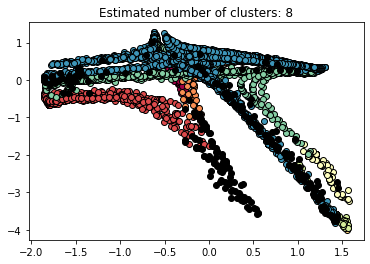

In [6]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Percentage of points that are noise: ", round(n_noise_/len(X)*100,1,))


# #############################################################################
# Plot result


# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [7]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))


Silhouette Coefficient: 0.412


In [8]:
#locate outliers. anything not in top 95% is an outlier in this current code
threshold = pd.Series(db.outlier_scores_).quantile(0.95)
outliers = X[np.where(db.outlier_scores_ > threshold)[0]]